In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np 
import scipy.linalg as sl
import h5ify 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.lines as mlines
import importlib
import json
from gwpy.timeseries import TimeSeries
import seaborn as sns
sns.set_palette('dark')

import os, sys
sys.path.append('/mnt/home/smiller/src/time-domain-gw-inference/')
from time_domain_gw_inference import group_postprocess, utils, run_sampler

### Load likelihood manager

In [2]:
# Get likelihood manager
data = group_postprocess.load_run_settings_from_directory(
    './output/250805_output', 
    filename_dict={'full':'full_0.0seconds'}
)
lm = data['runs']['full']['likelihood_manager']

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!
warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


### Plot PSDs

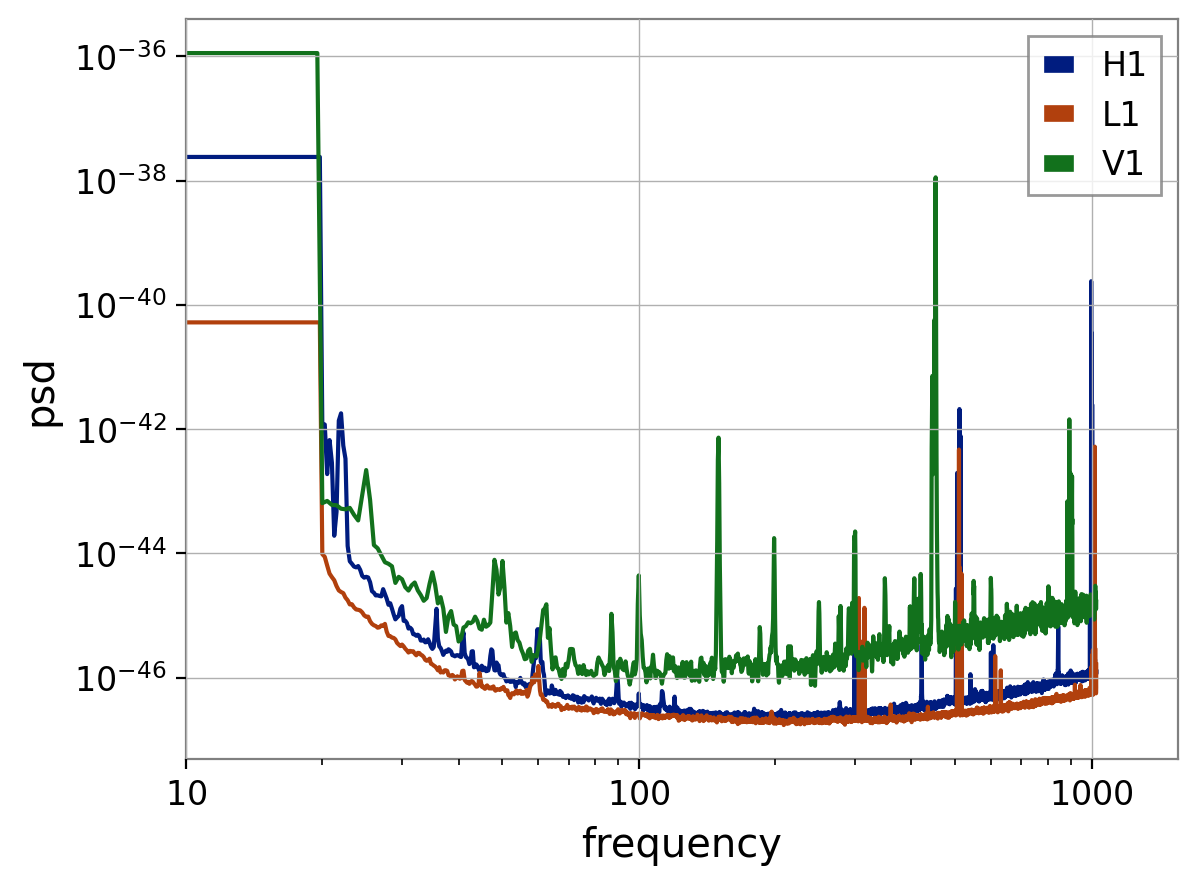

In [3]:
# Plot conditioned PSD
plt.figure()
for i, ifo in enumerate(lm.ifos): 
    freq, psd = lm.conditioned_psd_dict[ifo].transpose()
    plt.loglog(freq, psd, color=f'C{i}', label=ifo)
plt.xlabel('frequency')
plt.ylabel('psd')
plt.legend()
plt.xlim(10,)
plt.show()

### Plot ACF

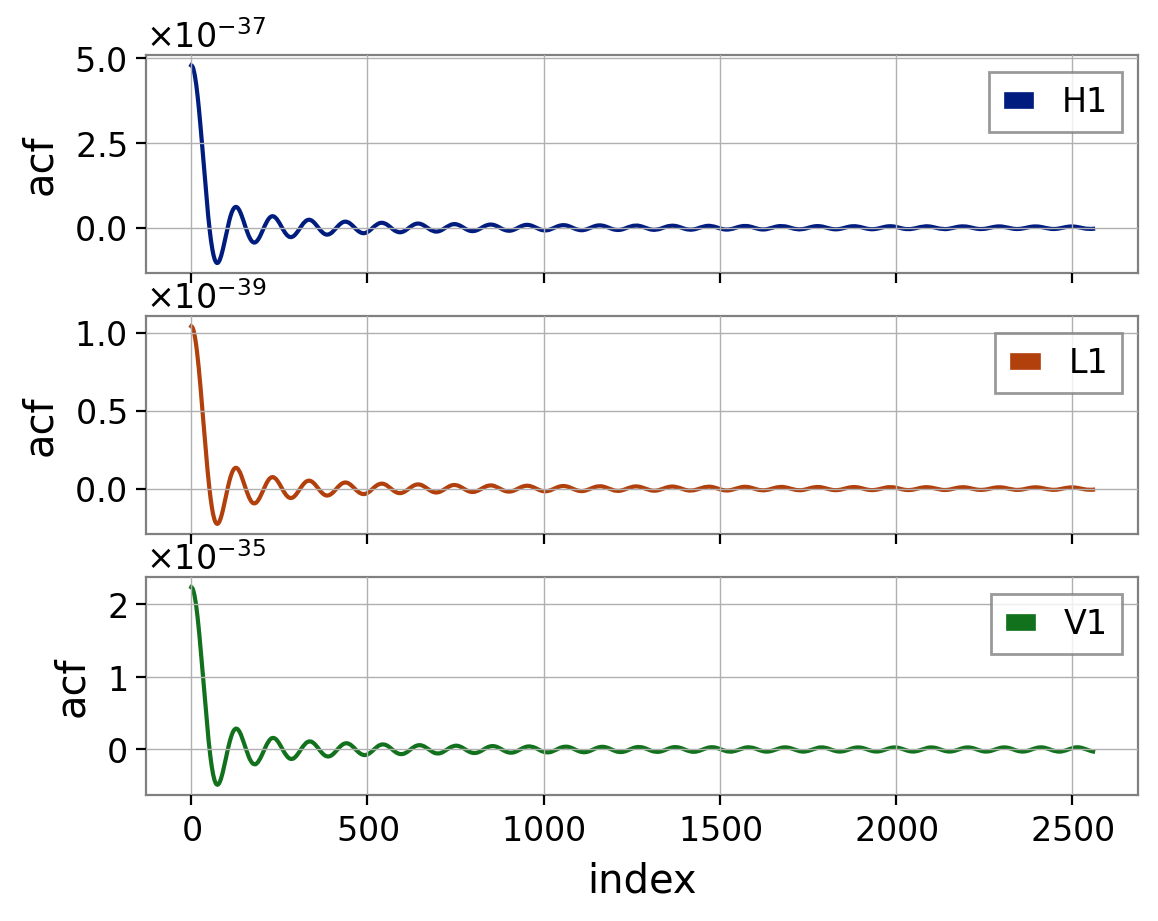

In [4]:
fig, axes = plt.subplots(3,1, sharex=True)

for i, (ifo, ax) in enumerate(zip(lm.ifos, axes)): 
    
    acf = lm.rho_dict[ifo]
    ax.plot(acf, color=f'C{i}', label=ifo)
    ax.legend()
    ax.set_ylabel('acf')

axes[-1].set_xlabel('index')
plt.show()

### Get injection

In [5]:
# get reference parameters
with open('./input/injection.json') as f:
    reference_parameters = json.load(f)

# Get detector delay times 
dt_dict = lm.waveform_manager.antenna_and_time_manager.compute_time_delay_dict(
    data['runs']['full']['kwargs']['right_ascension'], 
    data['runs']['full']['kwargs']['declination'], 
    lm.reference_time, 
    lm.ifos
)

In [6]:
# Get injection
reference_parameters_transformed = run_sampler.modify_parameters(reference_parameters, data['runs']['full']['args'])
injection_dict = lm.waveform_manager.get_projected_waveform(
    reference_parameters_transformed,
    lm.ifos,
    lm.time_dict,
    lm.f22_start, 
    lm.f_ref
)

warning! neither mean_anomaly nor mean_anomaly_periastron in df.columns!


### Plot strain

In [7]:
wh_dict = {}

# Get whitened strain and injection 
for i, ifo in enumerate(lm.ifos): 
                
    ACF = utils.get_ACF(
        lm.psd_dict,
        lm.time_dict, 
        f_low=lm.f_low, 
        f_max=lm.f_max,
    )[ifo]

    # Get whitened strain 
    C = sl.toeplitz(ACF)
    L = sl.cholesky(C,lower=True)
    wh_strain = sl.solve_triangular(L, lm.data_dict[ifo], lower=True)
    wh_inj = sl.solve_triangular(L, injection_dict[ifo], lower=True)

    wh_dict[ifo] = {'strain':wh_strain, 'inj':wh_inj}

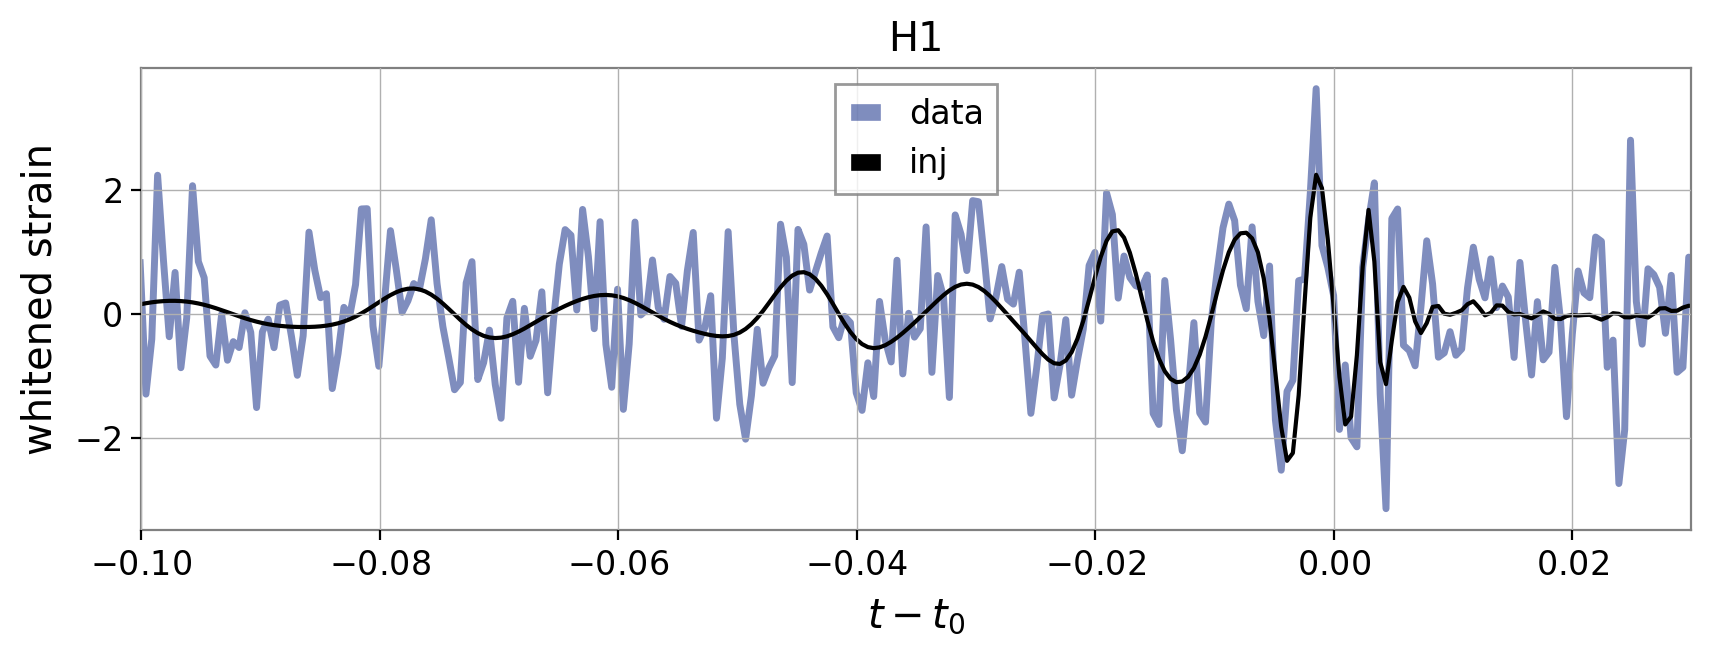

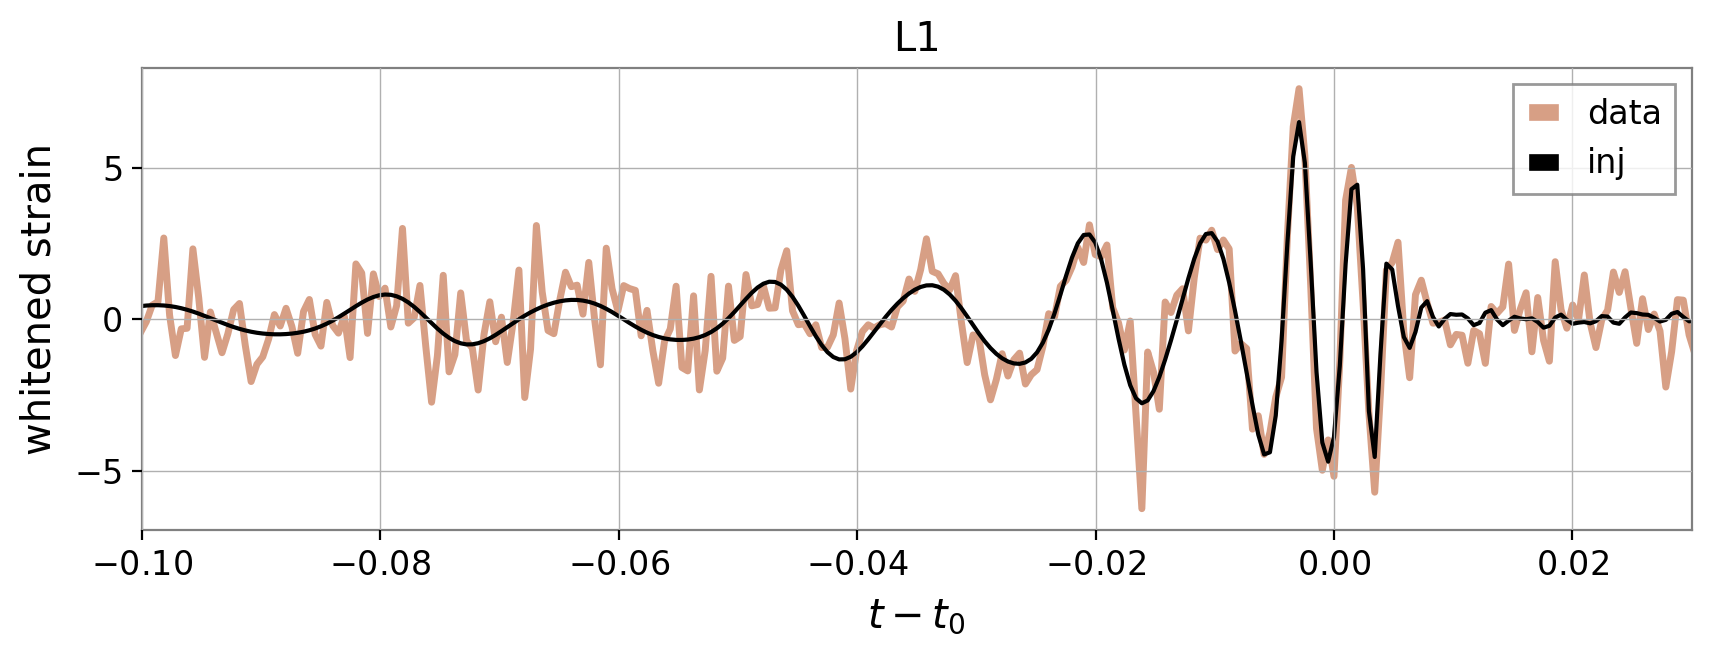

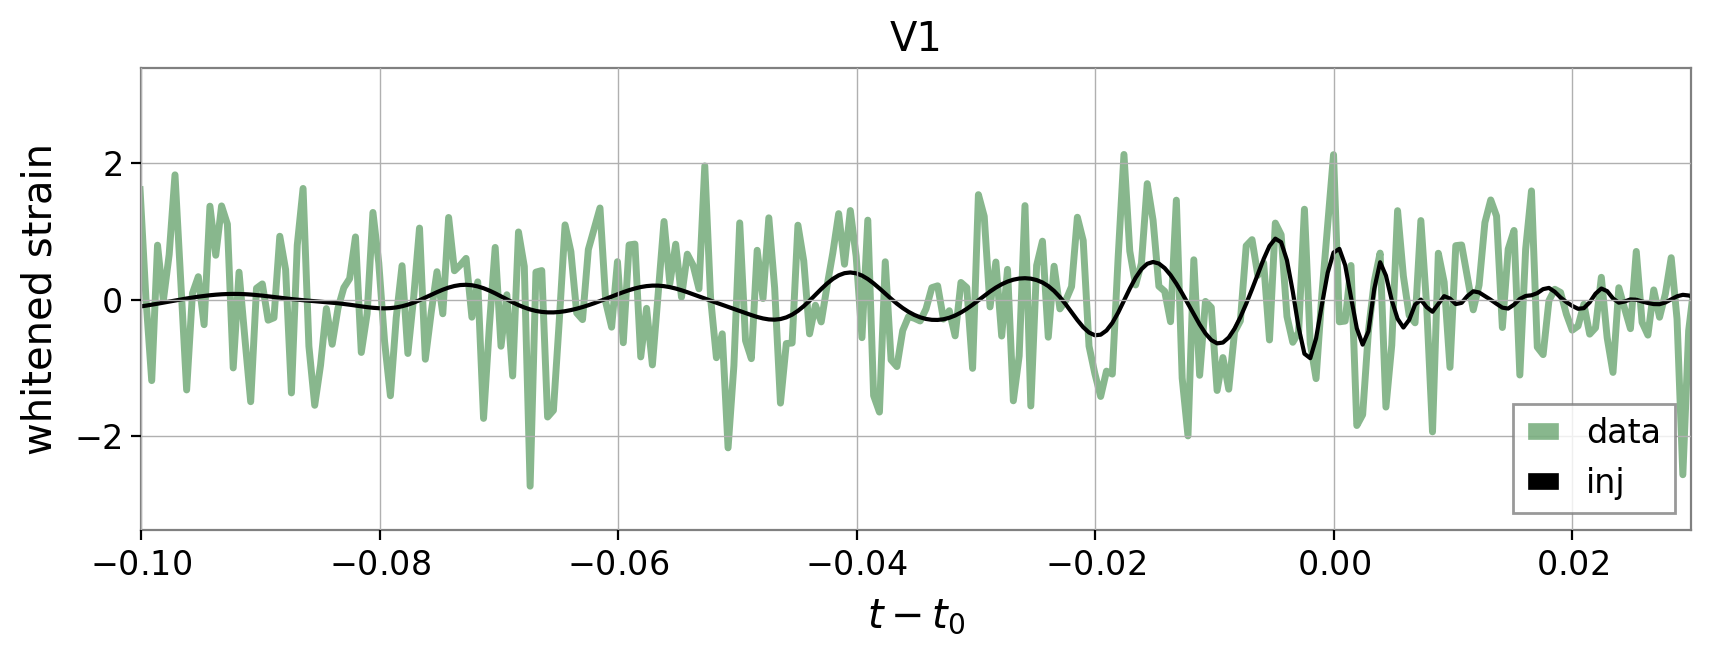

In [8]:
for i, ifo in enumerate(lm.ifos): 

    plt.figure(figsize=(10, 3))
    
    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]
    
    # Plot
    plt.plot(times, wh_dict[ifo]['strain'], color=f'C{i}', alpha=0.5, lw=2.5, label='data')
    plt.plot(times, wh_dict[ifo]['inj'], color='k', label='inj')

    plt.title(ifo)
    plt.xlabel('$t - t_0$')
    plt.ylabel('whitened strain')
    plt.xlim(-0.1, 0.03)
    plt.legend()
    plt.show()

### Cumulative SNR check

In [13]:
SNR_dict = {}

for ifo in lm.ifos: 
    
    d = wh_dict[ifo]['strain']
    inj = wh_dict[ifo]['inj']

    cum_snr = np.sqrt(np.cumsum(np.abs(inj*inj)))
    cum_snr_2 = np.sqrt(np.cumsum(np.abs(inj*inj)[::-1]))

    SNR_dict[ifo] = {'from start':cum_snr, 'from end':cum_snr_2}

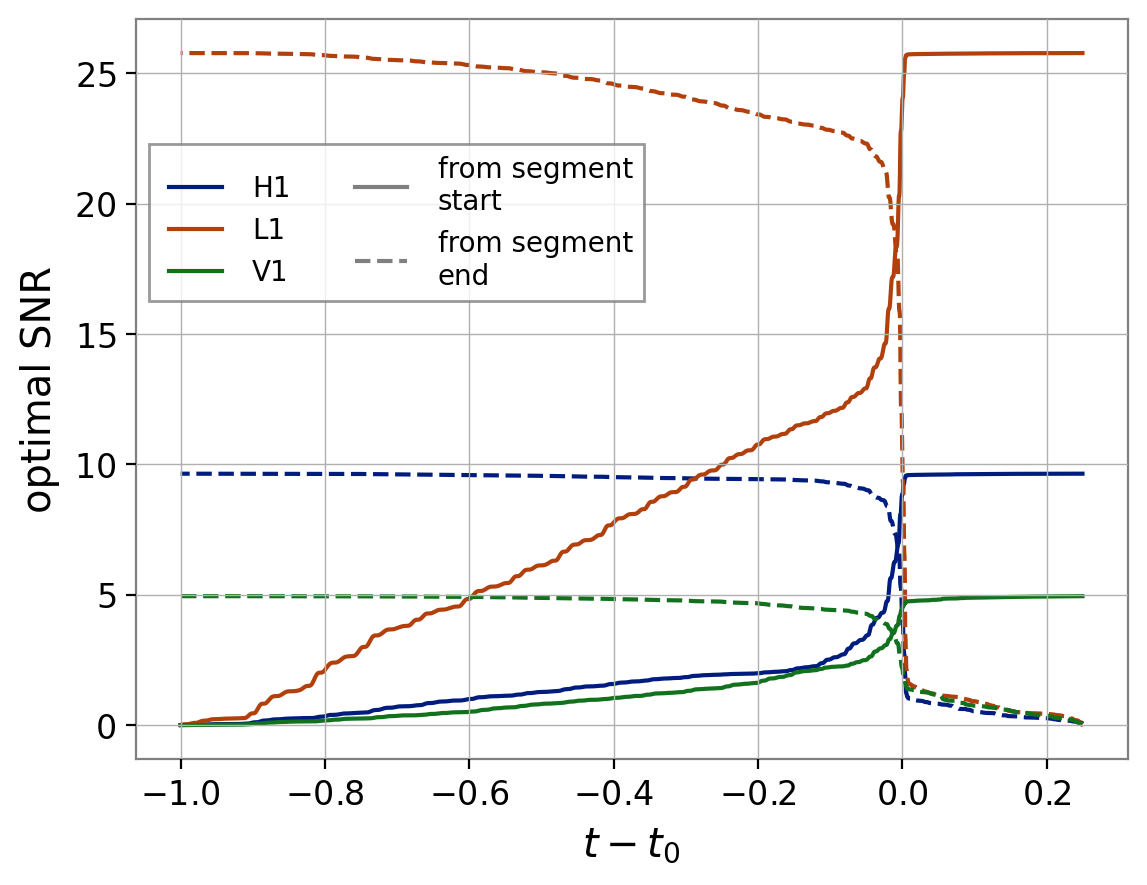

In [14]:
plt.figure()

for i,ifo in enumerate(lm.ifos): 

    times = lm.time_dict[ifo] - lm.reference_time - dt_dict[ifo]

    plt.plot(times, SNR_dict[ifo]['from start'], color=f'C{i}',label=ifo)
    plt.plot(times[::-1], SNR_dict[ifo]['from end'], color=f'C{i}', ls='--')

# customize legend
handles, _ = plt.gca().get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='gray', label='from segment\nstart'))
handles.append(mlines.Line2D([], [], color='gray', ls='--', label='from segment\nend'))
leg = plt.legend(handles=handles, ncols=2,handlelength=2.5, 
                 fontsize=10, loc='lower left', bbox_to_anchor=(0, 0.6))
for i, h in enumerate(handles):
    leg.get_lines()[i].set_linewidth(1.5)
    
plt.xlabel('$t - t_0$')
plt.ylabel('optimal SNR')
plt.show()